@author: Valentin Larrieu

# Affairs dataset


## Dataset

The dataset chosen is the [affairs dataset](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html) that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a [1978 paper](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf) from the Journal of Political Economy.

## Description of Variables

The dataset contains 6366 observations of 9 variables:

* **`rate_marriage`**: woman's rating of her marriage (1 = very poor, 2 = poor, 3 = fair, 4 = good, 5 = very good)
* **`age`**: woman's age
* **`yrs_married`**: number of years married
* **`children`**: number of children
* **`religious`**: woman's rating of how religious she is (1 = not, 2 = mildly, 3 = fairly, 4 = strongly)
* **`educ`**: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* **`occupation`**: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* **`occupation_husb`**: husband's occupation (same coding as above)
* **`affairs`**: measure of time spent in extramarital affairs

## Problem Statement

We decided to treat this as a classification problem by creating a new binary variable **`affair`** (did the woman have at least one affair?) and trying to predict the classification for each woman.

In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load dataset
df0 = sm.datasets.fair.load_pandas().data
# add "affair" column: 1 represents having affairs, 0 represents not
df0['affair'] = (df0.affairs > 0).astype(int)
df=df0.drop('affairs', axis=1, inplace = False)
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


## Data Exploration

In [3]:
print(df.isnull().sum())
print(df.info())
# there is no nan values

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affair             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
rate_marriage      6366 non-null float64
age                6366 non-null float64
yrs_married        6366 non-null float64
children           6366 non-null float64
religious          6366 non-null float64
educ               6366 non-null float64
occupation         6366 non-null float64
occupation_husb    6366 non-null float64
affair             6366 non-null int32
dtypes: float64(8), int32(1)
memory usage: 422.8 KB
None


In [4]:
df.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb
affair,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the `rate_marriage` variable.

In [5]:
df.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
rate_marriage,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.181446


## Data Visualization

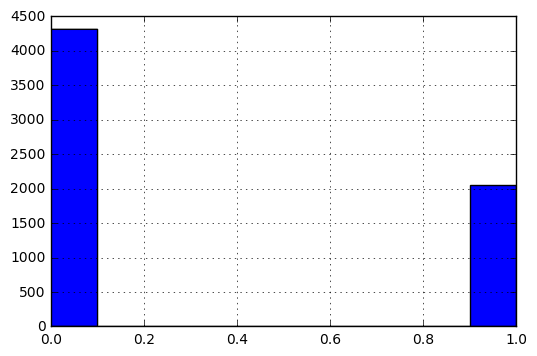

In [6]:
# yAffair repartition
df['affair'].hist(bins=10)

In [7]:
df.groupby('affair').size()*100/df.shape[0]
#woman who had an afair represent 32.2495 %

affair
0    67.75055
1    32.24945
dtype: float64

Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.

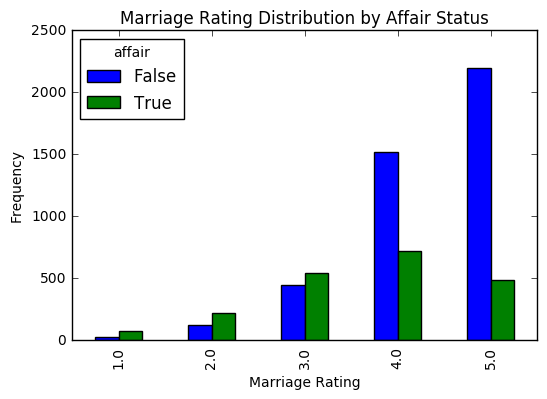

In [8]:
pd.crosstab(df.rate_marriage, df.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

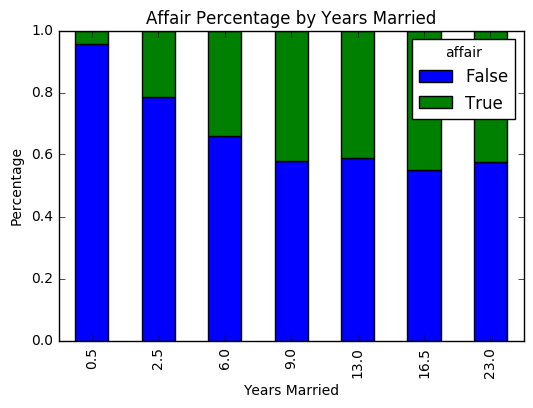

In [9]:
affair_yrs_married = pd.crosstab(df.yrs_married, df.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

## Model Training & Evaluation

In [10]:
y = df.affair
X = df.drop('affair',axis=1,inplace=False) 
print (X.columns)

Index(['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ',
       'occupation', 'occupation_husb'],
      dtype='object')


In [11]:
# We split the dataset
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print ("train shape", X_train.shape, y_train.shape)
print ("test shape", X_test.shape, y_test.shape)

train shape (4456, 8) (4456,)
test shape (1910, 8) (1910,)


In [12]:
# we create our model, here a logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=1)
clf.fit(X_train,y_train)

train_score=clf.score(X_train,y_train)
test_score=clf.score(X_test,y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

train accuracy = 0.726660682226
test accuracy = 0.713089005236


In [13]:
# confusion matrix here
y_pred = clf.predict(X_test) 

from sklearn import metrics
conf_mat=metrics.confusion_matrix(y_test, y_pred)
print (conf_mat)

#precision 
precision=conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
#Recall 
recall=conf_mat[1][1]/(conf_mat[1][1]+conf_mat[0][1])



[[1162  123]
 [ 425  200]]


In [14]:

print ('precision_0 =', precision)
print ('recall_1 =', recall)

print ("Verification : \n', metrics.classification_report(y_test, y_pred))

SyntaxError: EOL while scanning string literal (<ipython-input-14-90b03bf4f42b>, line 5)

In [ ]:
# We use cross validation
from sklearn import cross_validation

clf = LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(clf, X, y, scoring='accuracy', cv=5)

print ('scores mean =', scores.mean(), 'scores std =', scores.std())
#we compare it to the previous results :
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)
#As we can see the mean score is here better than the test accuracy

Let's predict the probability of an affair for a random woman not present in the dataset. She's a 25-year-old teacher who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [ ]:
clf = LogisticRegression(random_state=1)
clf.fit(X_train, y_train)
test_woman=np.array([3,25,3,1,4,16,4,2]) 

y_pred = clf.predict_proba(test_woman.reshape(1,-1))[0]
print("Affair probability is",round(y_pred[1]*100,2),"%")

## Improvment of the model

In [ ]:

df['Common_prof_rate'] = ((df['occupation'])/df['occupation_husb']).astype(float) # we construct a new feature, the occupation rate
print("nouveau df :\n", df.head())

y = df.affair
X = df.drop('affair',axis=1,inplace=False) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

clf = LogisticRegression(random_state=1)
clf.fit(X_train,y_train)

train_score=clf.score(X_train,y_train)
test_score=clf.score(X_test,y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

# The result is a bit better

In [ ]:
df['rate_mariage/yrs_marriage'] = ((df['rate_marriage'])/df['yrs_married']).astype(float) # we construct a new feature, the mariage rate
print("nouveau df :\n", df.head())

y = df.affair
X = df.drop('affair',axis=1,inplace=False) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

clf = LogisticRegression(random_state=1)
clf.fit(X_train,y_train)

train_score=clf.score(X_train,y_train)
test_score=clf.score(X_test,y_test)
print ('train accuracy =', train_score)
print ('test accuracy =', test_score)

# better score
